# Regression Tree

It's time to design our generic regression tree model that can be applied to any player. It will be based on the regression tree we designed using Federer as an exemple.

In [1]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We select the player and generate a table containing that player's matches which we will store in "player.csv", as to avoid creating one table for each player.  
Note : This setup step has to be repeated each time we change players.

In [11]:
### CLEAN PLAYER MATCHES TABLES ###

PLAYER = "Novak Djokovic"
setup = False

if (setup) :    # Creating the table (if the player.csv table currently contains information for another player)

    atp = pd.read_csv("atp_cat.csv")

    player_won = atp[atp["winner_name"] == PLAYER]
    player_lost = atp[atp["loser_name"] == PLAYER]

    # We'll drop all of the player's information except his age and rank
    player_won = player_won.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    player_won = player_won.rename(columns={"winner_age": "player_age", "winner_rank": "player_rank", "winner_rank_points": "player_rank_points",
                                    "loser_name":"opp_name", "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_ioc":"opp_ioc", "loser_age":"opp_age",
                                    "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
    player_won["index2"] = player_won.index
    player_won["player_won"] = "1"

    player_lost = player_lost.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
    player_lost = player_lost.rename(columns={"loser_age": "player_age", "loser_rank": "player_rank", "loser_rank_points": "player_rank_points",
                                        "winner_name":"opp_name", "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_ioc":"opp_ioc", "winner_age":"opp_age",
                                        "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
    player_lost["index2"] = player_lost.index
    player_lost["player_won"] = "0"

    player = pd.concat([player_won, player_lost])
    player = player.drop(["Unnamed: 0", "index2"] , axis=1)
    player.sort_index(inplace=True)

    # Win streaks
    result = player.player_won.astype(int)
    consecutive = result.groupby((result != result.shift()).cumsum()).cumcount()
    wins = pd.DataFrame({"win" : result, "consecutive" : consecutive})
    m = wins.win == 1
    wins.consecutive = wins.consecutive.where(m, 0)
    player["consecutive"] = wins.consecutive

    player.to_csv("player.csv")     # Saving the table for ease of use

else :  # player.csv already contains this player's information

    player = pd.read_csv("player.csv")

display(player)
print(f"{PLAYER} has {len(player)} recorded matches.")

,Unnamed: 0,tourney_name,surface,tourney_level,tourney_date,player_age,opp_name,opp_hand,opp_ht,opp_ioc,...,score,best_of,round,minutes,player_rank,player_rank_points,opp_rank,opp_rank_points,player_won,consecutive
0,39968,Bangkok,Hard,A,20040927,17.352498,Dennis Van Scheppingen,R,185.0,NED,...,4-6 7-5 6-4,3,R32,112.0,248.0,148.0,81.0,496.0,0,0
1,41582,Umag,Clay,A,20040719,17.160849,Filippo Volandri,R,183.0,ITA,...,7-6(5) 6-1,3,R32,90.0,368.0,83.0,65.0,630.0,0,0
2,42684,Bucharest,Clay,A,20040913,17.314168,Arnaud Clement,R,173.0,FRA,...,2-6 6-4 6-4,3,R32,146.0,272.0,128.0,67.0,623.0,1,0
3,42693,Bucharest,Clay,A,20040913,17.314168,David Ferrer,R,175.0,ESP,...,4-6 6-4 6-4,3,R16,155.0,272.0,128.0,54.0,714.0,0,0
4,43520,Paris Masters,Carpet,M,20051031,18.444901,Victor Hanescu,R,198.0,ROU,...,4-1 RET,3,R64,19.0,85.0,488.0,37.0,853.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,86190,Us Open,Hard,G,20210830,34.275154,Kei Nishikori,R,178.0,JPN,...,6-7(4) 6-3 6-3 6-2,5,R32,212.0,1.0,11113.0,56.0,1208.0,1,24
1089,86206,Us Open,Hard,G,20210830,34.275154,Jenson Brooksby,R,NaN,USA,...,1-6 6-3 6-2 6-2,5,R16,179.0,1.0,11113.0,99.0,812.0,1,25
1090,86214,Us Open,Hard,G,20210830,34.275154,Matteo Berrettini,R,196.0,ITA,...,5-7 6-2 6-2 6-3,5,QF,207.0,1.0,11113.0,8.0,5533.0,1,26
1091,86218,Us Open,Hard,G,20210830,34.275154,Alexander Zverev,R,198.0,GER,...,4-6 6-2 6-4 4-6 6-2,5,SF,214.0,1.0,11113.0,4.0,8240.0,1,27


Novak Djokovic has 1093 recorded matches.


In [3]:


player.to_csv("player.csv")

player.tail(5)

,tourney_name,surface,tourney_level,tourney_date,player_age,opp_name,opp_hand,opp_ht,opp_ioc,opp_age,score,best_of,round,minutes,player_rank,player_rank_points,opp_rank,opp_rank_points,player_won,consecutive
86190,Us Open,Hard,G,20210830,34.275154,Kei Nishikori,R,178.0,JPN,31.668720,6-7(4) 6-3 6-3 6-2,5,R32,212.0,1.0,11113.0,56.0,1208.0,1,24
86206,Us Open,Hard,G,20210830,34.275154,Jenson Brooksby,R,NaN,USA,20.843258,1-6 6-3 6-2 6-2,5,R16,179.0,1.0,11113.0,99.0,812.0,1,25
86214,Us Open,Hard,G,20210830,34.275154,Matteo Berrettini,R,196.0,ITA,25.382615,5-7 6-2 6-2 6-3,5,QF,207.0,1.0,11113.0,8.0,5533.0,1,26
86218,Us Open,Hard,G,20210830,34.275154,Alexander Zverev,R,198.0,GER,24.361396,4-6 6-2 6-4 4-6 6-2,5,SF,214.0,1.0,11113.0,4.0,8240.0,1,27
86220,Us Open,Hard,G,20210830,34.275154,Daniil Medvedev,R,198.0,RUS,25.549624,6-4 6-4 6-4,5,F,136.0,1.0,11113.0,2.0,9980.0,0,0


## Regression Decision Tree

We will create a decision tree using these features :
- Surface  
- Best of  
- Opponent hand  
- Opponent height  
- Opponent country  
- Ranking difference  
- Tournament level  
- Match round (QF, SF, F, etc...)
- Player form  

Some of these features seem irrelevant, and they probably are. However, since we will use GridSearchCV to perform feature selection, we will feed the model all the information we have and let it select what is important (ie. the optimal splits in terms of information gain).

### Formatting

The "player.csv" table contains many unecessary columns. Here, we create a player1 table containing all the features we potentially need for our model and format them correctly. Specifically, we use one-hot encoding to split categorical data into multiple boolean columns.

In [4]:
player1 = player[["minutes", "surface", "best_of", "opp_hand", "opp_ht", "opp_age", "tourney_level", "round"]]
player1["rank_diff"] = player["player_rank"] - player["opp_rank"]
player1["consecutive"] = player["consecutive"]

# One-Hot Encoding
player1 = pd.get_dummies(data=player1, columns=["surface", "best_of", "opp_hand", "tourney_level", "round"])

player1 = player1.dropna(axis=0, how='any')

player1.head(5)

C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,minutes,opp_ht,opp_age,rank_diff,consecutive,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
39968,112.0,185.0,29.232033,167.0,0,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
41582,90.0,183.0,22.869268,303.0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
42684,146.0,173.0,26.740589,205.0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
42693,155.0,175.0,22.450376,218.0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
43520,19.0,198.0,24.279261,48.0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


### Regression Decision Tree



#### Pre-processing

For pre-processing we have three options :
- not scaling x or y
- scaling both x and y
- scaling x but not y   
  
I feel like scaling gives us better results but adds a hurdle in interpreting the tree's visualization since it displays scaled values. We can scale both input and output values back, just not display them with sklearns's plot_tree (or any tree visualization that I've found so far). For now, the roundabout solution is just to print out the scaled input and output.

In [12]:
### PRE-PROCESSING ###

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target='minutes'

scale_x = False
scale_y = False

def preprocessing(scale_x=False, scale_y=False) :

    # 1. X, y unscaled
    X = player1.drop([target], axis=1)
    y = np.asarray(player1[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        xscaler.fit(X[['opp_ht', 'opp_age', 'rank_diff']])
        X[['opp_ht', 'opp_age', 'rank_diff']] = xscaler.transform(X[['opp_ht', 'opp_age', 'rank_diff']])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    display(pd.DataFrame(X).head())
    display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

X, y, xscaler, yscaler = preprocessing(scale_x, scale_y)

,opp_ht,opp_age,rank_diff,consecutive,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
39968,185.0,29.232033,167.0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
41582,183.0,22.869268,303.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
42684,173.0,26.740589,205.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
42693,175.0,22.450376,218.0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
43520,198.0,24.279261,48.0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,1,0,0


,0
0,112.0
1,90.0
2,146.0
3,155.0
4,19.0


#### Building the tree

To build a good tree, we need to select values for the tree's parameters (e.g. max depth, minimum samples per leaf). We'll perform this "Hyperparameter Tuning" using GridSearchCV, a library which selects the best tree by trying every combination of parameters we give it and performing a cross validation. The trees are commpared based on the R² criteria.  
  
![score formula](res/score.png "sklearn score")  

In [6]:
### PARAMETER SELECTION ###

from sklearn.model_selection import GridSearchCV

params = {
    # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
    "max_depth":np.arange(3, 10), 
    "min_samples_leaf":np.arange(1, 80), 
    # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
    # "max_features":np.arange(1, 25)
}

dtr = DecisionTreeRegressor(random_state=42)
dtr_cv = GridSearchCV(dtr, params, scoring="r2", n_jobs=-1, verbose=1, cv=10)

In [7]:
### CUSTOM PREDICTION ###

def custom_predict(dtr, scale_x, scale_y, height, age, rank_diff, consecutive, surface, best_of, hand, level, round) :
    # returns the predicted length of a match given a set of match conditions

    # surface : carpet(1), clay(2), grass(3), hard(4)
    # best of : 3(1), 5(2)
    # hand : left(1), right(2)
    # level : A(1), D(2), F(3), G(4), M(5)
    # round : F(1), QF(2), R128(3), R16(4), R32(5), R64(6), R(7), SF(8)

    surface_input = [0, 0, 0, 0]
    surface_input[surface - 1] = 1

    bo_input = [0, 0]
    bo_input[best_of - 1] = 1

    hand_input = [0, 0]
    hand_input[hand - 1] = 1

    level_input = [0, 0, 0, 0, 0]
    level_input[level - 1] = 1

    round_input = [0, 0, 0, 0, 0, 0, 0, 0]
    round_input[round - 1] = 1

    if (not scale_x and not scale_y) :  # 1. X, y unscaled
        input = [height, age, rank_diff] + [consecutive] + surface_input + bo_input + hand_input + level_input + round_input
        print("Input : ", input)

        input = [input]

        print("Prediction : ", dtr.predict(input), " minutes")

    # input = [180, 0, 0, 0, 1, 0, 0, 0, 1]

    elif (scale_x and scale_y) :    # 2. X, y scaled
        input = xscaler.transform([[height, age, rank_diff]])
        input = np.append(input[0], consecutive, surface_input + bo_input + hand_input + level_input + round_input)
        print("Scaled input : ", input)

        input = [input]

        print("Scaled Prediction : ", dtr.predict(input), " minutes")
        print("Prediction : ", yscaler.inverse_transform(dtr.predict(input)), " minutes")

    elif (scale_x and not scale_y) :    # 3. X scaled, y unscaled
        input = xscaler.transform([[height, age, rank_diff]]).tolist()
        input = np.append(input[0], [consecutive] + surface_input + bo_input + hand_input + level_input + round_input)
        print("Scaled input : ", input)
        
        input = [input]

        print("Prediction : ", dtr.predict(input)[0], " minutes")

    return(dtr.predict(input)[0])

# prediction = predict(scale_x, scale_y, 180, 22, 0, 0, 4, 1, 2, 4, 5)

In [13]:
### THE LOOP ###

test_scores = []
predictions = []

for i in range(20) :

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)
    dtr_cv.fit(Xtrain, ytrain)

    best_params = dtr_cv.best_params_
    print(f"Best parameters: {best_params})")

    dtr = DecisionTreeRegressor(**best_params)
    dtr.fit(Xtrain, ytrain)

    # Testing :

    ypred = dtr.predict(Xtest)

    print(f"Training score {i+1} : ", dtr.score(Xtrain, ytrain))
    print(f"Testing score {i+1} : ", dtr.score(Xtest, ytest))
    test_scores.append(dtr.score(Xtest, ytest))

    predictions.append(custom_predict(dtr, scale_x, scale_y, 180, 22, 10, 0, 4, 1, 2, 4, 5))

print("Test scores : ", test_scores)
print("Test scores average : ", sum(test_scores)/len(test_scores))

print(predictions)
print(f"Average predicted length : {sum(predictions) / len(predictions)}")

Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1})
Training score 1 :  0.38254471064742723
Testing score 1 :  0.24283889644130507
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [112.03]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 7})
Training score 2 :  0.40806104882772565
Testing score 2 :  0.13691269101119552
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [105.93877551]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 6, 'min_samples_leaf': 48})
Training score 3 :  0.3718337560793543
Testing score 3 :  0.18444347690380192
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [109.09836066]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 40})
Training score 4 :  0.35262604970943
Testing score 4 :  0.28561430310429814
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [113.91525424]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 6, 'min_samples_leaf': 47})
Training score 5 :  0.3573942977728588
Testing score 5 :  0.2822162676294865
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [113.56363636]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 14})
Training score 6 :  0.3705152198335434
Testing score 6 :  0.23375523968107015
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.54268293]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 20})
Training score 7 :  0.3435347077854597
Testing score 7 :  0.30855316569347957
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.08839779]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 64})
Training score 8 :  0.34297931018202144
Testing score 8 :  0.26475442045701436
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [116.86021505]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 6, 'min_samples_leaf': 54})
Training score 9 :  0.31968878839933956
Testing score 9 :  0.32417738825139586
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [104.59375]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 7})
Training score 10 :  0.37012955030104
Testing score 10 :  0.30059774477488543
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [115.88888889]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 8})
Training score 11 :  0.3633730339520316
Testing score 11 :  0.3308877181352057
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.91558442]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 65})
Training score 12 :  0.3129741291498881
Testing score 12 :  0.3218741908977236
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [105.62820513]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 1})
Training score 13 :  0.3942984831218086
Testing score 13 :  0.17988373780439904
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [251.]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 41})
Training score 14 :  0.3435691841684737
Testing score 14 :  0.3029792983202204
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [107.85534591]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 17})
Training score 15 :  0.3401520575362319
Testing score 15 :  0.3296980692449234
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [108.30573248]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 4, 'min_samples_leaf': 13})
Training score 16 :  0.39643028144199344
Testing score 16 :  0.22422937167843893
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [134.875]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 16})
Training score 17 :  0.3858422788787017
Testing score 17 :  0.21657643102411972
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [166.70212766]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 78})
Training score 18 :  0.3420106636961888
Testing score 18 :  0.25431647996238926
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [103.66064982]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters: {'max_depth': 3, 'min_samples_leaf': 19})
Training score 19 :  0.3642025994742589
Testing score 19 :  0.22764891247662888
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [111.8195122]  minutes
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.2s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 37})
Training score 20 :  0.3818693284590835
Testing score 20 :  0.18623229842361633
Input :  [180, 22, 10, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
Prediction :  [185.48051948]  minutes
Test scores :  [0.24283889644130507, 0.13691269101119552, 0.18444347690380192, 0.28561430310429814, 0.2822162676294865, 0.23375523968107015, 0.30855316569347957, 0.26475442045701436, 0.32417738825139586, 0.30059774477488543, 0.3308877181352057, 0.3218741908977236, 0.17988373780439904, 0.3029792983202204, 0.3296980692449234, 0.22422937167843893, 0.21657643102411972, 0.25431647996238926, 0.22764891247662888, 0.18623229842361633]
Test scores average :  0.25690950509577987
[112.03, 105.93877551020408, 109.09836065573771, 113.91525423728814, 113.56363636363636, 108.54268292682927, 107.08839779005525, 116.86021505376344, 104.59375, 115.88888888888889, 108.91558441558442, 105.62820512820512, 251.0, 107.85534591194968, 108.305732484

[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.0s finished


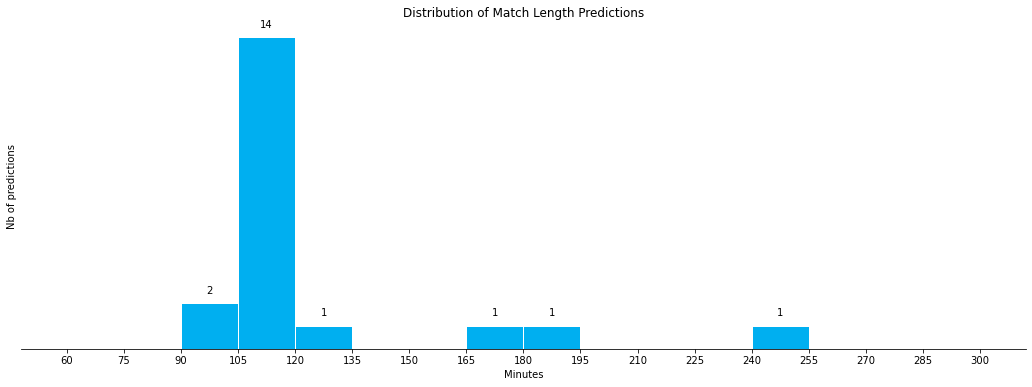

In [68]:
### HISTOGRAM ###

# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0

time_step = 15  # precision : 15/30/30 minutes
intervals=np.arange(60, 300 + time_step, time_step)

fig, ax = plt.subplots(1, figsize=(18,6))

n, bins, patches = plt.hist(predictions, bins=intervals, color='#00AFF0')

plt.xticks(bins)
plt.grid(color='white', lw = 1, axis='x')

plt.title('Distribution of Match Length Predictions')
plt.xlabel("Minutes")
plt.ylabel("Nb of predictions")

# ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
plt.yticks([])

for idx, value in enumerate(n) :
    if value > 0 :
        plt.text(xticks[idx], value + 0.5, int(value), ha='center')

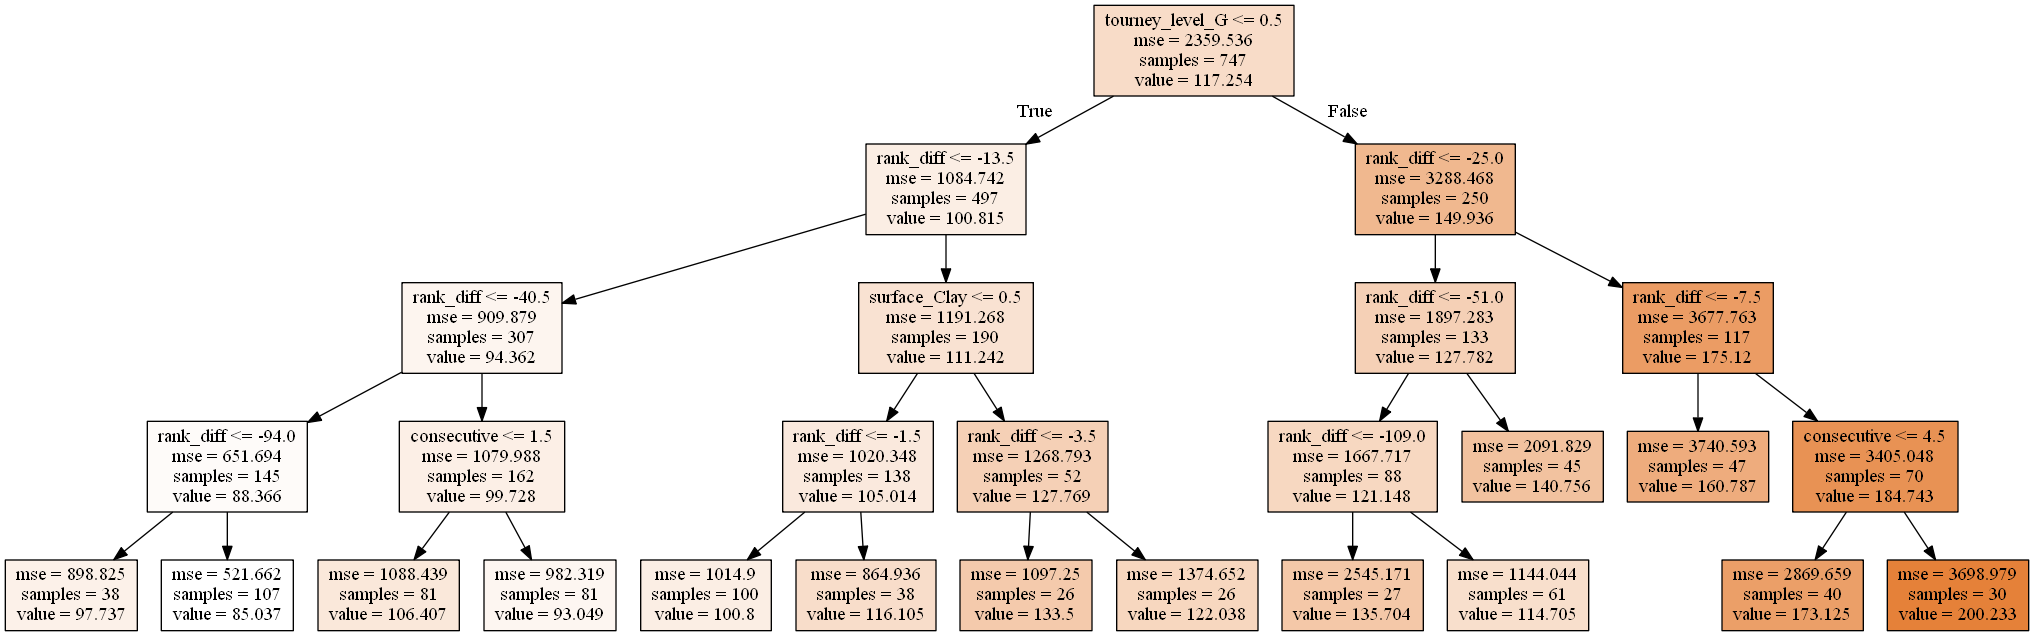

In [10]:
# TREE VISUALIZATION

# Without True/False (sklearn)

# x_ax = range(len(ytest))
# plt.plot(x_ax, ytest, linewidth=1, label="original")
# plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
# plt.title("Y-test and y-predicted data")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend(loc='best',fancybox=True, shadow=True)
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(30,15))
# tree.plot_tree(dtr,
#           filled=True,
#           rounded=True,
#           fontsize=10,
#           feature_names=["opp_ht", "opp_age", "rank_diff", "consecutive", "surface_Carpet", "surface_Clay", "surface_Grass", "surface_Hard", 
#                          "best_of_3", "best_of_5", "opp_hand_L", "opp_hand_R", 
#                          'tourney_level_A', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M', 
#                          'round_F', 'round_QF', 'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF'])

# # plt.savefig('tree_high_dpi', dpi=600)

# # With True/False label (pydot)

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

# def visualize_tree(dtr) :

features = list(player1.columns)
features.remove("minutes")

dot_data = StringIO()
export_graphviz(dtr, out_file=dot_data, feature_names=features, filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

# visualize_tree(dtr)